# Project 4: Predicting Volatility Index price with Sentiment Analysis on News headlines

### Notebook 3 : Classifier Models - For Volatility Index Price Direction (Up or Down) 

This portion of the notebook will be modelling to predict if VIX (Y variable) is up or down on , we will be using the below models :

1. 3 layers of Stacked LSTM

In [21]:
# To isntall  keras run the below command
!pip install keras

In [1]:
# INSTALLING Tensorflow 
#Use Anaconda prompt and run the command 'pip install tensorflow==2.0.0'

# Importing Libraries

In [24]:
# get some libraries that will be useful
import re
import numpy as np
# fix random seed for reproducibility
np.random.seed(7)
import pandas as pd
import seaborn as sns
import string
import matplotlib.pyplot as plt

# function for train_test_split
from sklearn.model_selection import train_test_split

#keras modeling
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers.convolutional import Convolution1D
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score, accuracy_score

In [25]:
# grab the data #we will first grab the news data set first
combined_news = pd.read_csv("../data/final_dataframe.csv")

In [26]:
combined_news.head()

,Date,all25,upordown
0,2008-08-08,"0,b""georgia 'downs two russian warplanes' as c...",0.0
1,2008-08-11,"1,b'why wont america and nato help us? if they...",0.0
2,2008-08-12,"0,b'remember that adorable 9-year-old who sang...",1.0
3,2008-08-13,"0,b' u.s. refuses israel weapons to attack ira...",0.0
4,2008-08-14,"1,b'all the experts admit that we should legal...",0.0


# DEEP LEARNING

## LSTM + tokenizer

In [27]:
# We will define our X and Y variables before we head into the machine learning.

In [28]:
X = combined_news
y = combined_news['upordown']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30,stratify = y)

In [29]:
#for our training set, we only want the'all25 column'
trainheadlines = []
for row in range(0,len(X_train.index)):
    trainheadlines.append(' '.join(str(x) for x in X_train.iloc[row,1:3]))

In [30]:
#we will perform the same for the validation set
testheadlines = []
for row in range(0,len(X_val.index)):
    testheadlines.append(' '.join(str(x) for x in X_val.iloc[row,1:3]))

### Next we will vectorize the text samples into a 2D integer tensor for processing

In [31]:
#num_words - This will be the maximum number of words 
#from our resulting tokenized data vocabulary which are to be used, 
#truncated after the 10000 most common words in our case.
tokenizer = Tokenizer(num_words=10000)
# Tokenize our training data'trainheadlines'
tokenizer.fit_on_texts(trainheadlines)
# Encode training data sentences into sequences for both train and test data.
sequences_train = tokenizer.texts_to_sequences(trainheadlines)
sequences_test = tokenizer.texts_to_sequences(testheadlines)

In [32]:
print('Pad sequences (samples x time)')

#Features for model training
#nb_classes - total number of classes.
nb_classes = 2
# maxlen is feature of maximum sequence length for padding our encoded sentences
maxlen = 200

# Pad the training sequences as we need our encoded sequences to be of the same length. 
# use that to pad all other sequences with extra '0's at the end ('post') and
# will also truncate any sequences longer than maximum length from the end ('post') as well. 
X_train = sequence.pad_sequences(sequences_train, maxlen=maxlen)
X_val = sequence.pad_sequences(sequences_test, maxlen=maxlen)

#convert them into array before we put them into model
y_train = np.array(y_train)
y_val = np.array(y_val)

# np_utils.to_categorical to convert array of labeled data(from 0 to nb_classes-1) to one-hot vector.
Y_train = np_utils.to_categorical(y_train, 2)
Y_val = np_utils.to_categorical(y_val, 2)

#print out X_train and X_test shape.
print('X_train shape:', X_train.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', Y_train.shape)
print('y_val shape:', Y_val.shape)

Pad sequences (samples x time)
X_train shape: (1392, 200)
X_val shape: (597, 200)
y_train shape: (1392, 2)
y_val shape: (597, 2)


# 3 layers of Stacked LSTM for sequence classification

Sequence classification is a predictive modeling problem where you have some sequence of inputs over space or time and the task is to predict a category for the sequence which may apply in this case.

In [33]:
print('Build LSTM model...')
# expected input data shape: (batch_size, timesteps, data_dim)
data_dim = 16
timesteps = 8
max_features = 10000
#intialize model
model = Sequential()
#Embedding with 128
model.add(Embedding(max_features, 128))
#add a dropout-this is to prevent overfitting
model.add(Dropout(0.2))
# returns 16 sequences of vectors of dimension 32
model.add(LSTM(32, return_sequences=True,input_shape=(timesteps, 16)))  
#add 2nd dropout
model.add(Dropout(0.2))
# returns a sequence of vectors of dimension 32
model.add(LSTM(32, return_sequences=True)) 
#add 3rd dropout
model.add(Dropout(0.2))
# return a single vector of dimension 32
model.add(LSTM(32))  
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())

Build LSTM model...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 32)          20608     
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, None, 32)          8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_6 (LSTM)                (None

In [34]:
# Final evaluation of the model
history = model.fit(X_train, Y_train,
          batch_size=64, epochs=3,
          validation_data=(X_val, Y_val))

C:\Users\derri\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 1392 samples, validate on 597 samples
Epoch 1/3
1392/1392 [==============================] - 11s 8ms/step - loss: 0.6739 - accuracy: 0.5984 - val_loss: 0.6599 - val_accuracy: 0.6030
Epoch 2/3
1392/1392 [==============================] - 11s 8ms/step - loss: 0.5786 - accuracy: 0.6322 - val_loss: 0.6280 - val_accuracy: 0.6332
Epoch 3/3
1392/1392 [==============================] - 9s 7ms/step - loss: 0.1605 - accuracy: 0.9598 - val_loss: 0.5681 - val_accuracy: 0.7588


In [35]:
print("Generating training accuracy...")
#We take an average of the training accuracy score
trainingacc5 = np.mean(history.history['accuracy'])
print('Training Accuracy Score: ',trainingacc5)
trainingvalacc5 = np.mean(history.history['val_accuracy'])
print('Training Validation Score: ',trainingvalacc5)

Generating training accuracy...
Training Accuracy Score:  0.73012453
Training Validation Score:  0.6649916172027588


In [36]:
print("Generating test predictions...")
score, acc = model.evaluate(X_val, Y_val,batch_size=64)
preds5 = model.predict_classes(X_val, verbose=0)
acc5 = accuracy_score(y_val, preds5)
print('Prediction accuracy: ', acc5)

Generating test predictions...
597/597 [==============================] - 1s 1ms/step
Prediction accuracy:  0.7587939698492462


In [37]:
# predict ROC-AUC score 
predictions = model.predict_proba(X_val)
rocauc5 = str(roc_auc_score(Y_val, predictions))
print("ROC-AUC-score5 :", rocauc5)

ROC-AUC-score5 : 0.8206047819971871


Based on the chart above, we can deduce that the accuracy rises for both test and training set while the loss falls as well.

In [38]:
# Create a dataframe called pred_df that contains:
# 1. The list of true values of our validation set.
# 2. The list of predicted probabilities based on our model.

true_y = [i[1] for i in Y_val]

pred_proba = [i[1] for i in model.predict_proba(X_val)]

pred_df = pd.DataFrame({'true_values': true_y,'pred_probs':pred_proba})

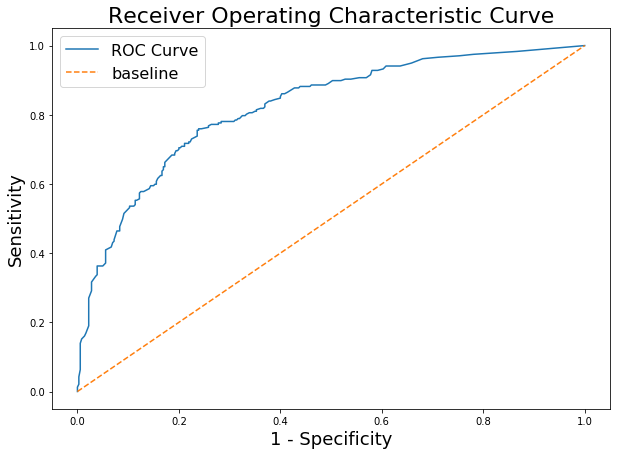

In [39]:
#Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

- To summarise, we have successfully trained a model that can predict whether the news headlines will contribute to a rise or fall to our volatiliy index.